<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    Mini-Challenge 2:<br>Paper-Studium und Umsetzung
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Gabriel Torres Gamez im FS 2023.
</p>

## Ziel
Vertiefung in ein eher aktuelles Paper aus der Forschung und Umsetzung eines darin <br>
beschriebenen oder verwandten Tasks - gemäss Vereinbarung mit dem Fachcoach.  

Beispiel: Implementiere, trainiere und validiere ein Deep Learning Modell für Image <br>
Captioning wie beschrieben im Paper Show and Tell.

## Setup
Hier wird vor der Bearbeitung alles aufgesetzt.

In [1]:
# Standard Libraries
import os
import sys
import logging
import warnings

# 3rd Party Libraries
import matplotlib as mpl
import nltk
import numpy as np
import pandas as pd
import pytorch_lightning as li
import torch
import torchaudio
import torchmetrics
import torchvision
import tqdm
import wandb

## Specific Imports
from argparse import Namespace
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize as nltk_word_tokenize
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from tqdm.notebook import trange, tqdm as tqdm_

# Print information about the environment
print("Packages: ")
print(f" | Python Version: {sys.version}")
print(f" | Matplotlib Version: {mpl.__version__}")
print(f" | NLTK Version: {nltk.__version__}")
print(f" | Numpy Version: {np.__version__}")
print(f" | Pandas Version: {pd.__version__}")
print(f" | PyTorch Lightning Version: {li.__version__}")
print(f" | PyTorch Version: {torch.__version__}")
print(f" | Torchaudio Version: {torchaudio.__version__}")
print(f" | Torchmetrics Version: {torchmetrics.__version__}")
print(f" | Torchvision Version: {torchvision.__version__}")
print(f" | tqdm Version: {tqdm.__version__}")
print(f" | Wandb Version: {wandb.__version__}")
print()

print("Backends: ")
print(f" | CUDA: {torch.cuda.is_available()}")
print(f"   | CUDA Built: {torch.backends.cuda.is_built()}")
print(f" | MPS: {torch.backends.mps.is_available()}")
print(f"   | MPS Built: {torch.backends.mps.is_built()}")
print()

print("Ressources: ")
print(f" | CPU Threads: {torch.get_num_threads()}")
for i in range(torch.cuda.device_count()):
    print(f" | GPU {i+1}: {torch.cuda.get_device_name(i)}\n")

# Settings
torch.set_float32_matmul_precision("high")
nltk.download('punkt')
seed = torch.Generator().manual_seed(42)

# silent warnings
%env WANDB_SILENT=True
warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Final message
print("Setup complete!\n")

Packages: 
 | Python Version: 3.11.6 (main, Oct  2 2023, 13:45:54) [Clang 15.0.0 (clang-1500.0.40.1)]
 | Matplotlib Version: 3.8.2
 | NLTK Version: 3.8.1
 | Numpy Version: 1.25.2
 | Pandas Version: 2.1.2
 | PyTorch Lightning Version: 2.1.2
 | PyTorch Version: 2.1.1
 | Torchaudio Version: 2.1.1
 | Torchmetrics Version: 1.2.0
 | Torchvision Version: 0.16.1
 | tqdm Version: 4.66.1
 | Wandb Version: 0.16.0

Backends: 
 | CUDA: False
   | CUDA Built: False
 | MPS: True
   | MPS Built: True

Ressources: 
 | CPU Threads: 8
env: WANDB_SILENT=True
Setup complete!



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gabriel.torres/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Hyperparameters

In [2]:
# Files
img_path = "data/images"
ann_file = "data/captions.txt"

# Tokenizer
tokenizer = nltk_word_tokenize

# Bild Embedder 
img_embed_size = 1000

# Data Loader 
num_workers = 0
batch_size = 64
val_ratio = 0.1
test_ratio = 0.2

# NIC
embed_size = img_embed_size
hidden_size_lstm = 1000
num_layers_lstm = 10

## Arbeitsschritte

### Schritt 1: Daten 
Für diese MiniChallenge wird der Flickr8k Datensatz verwendet. 

#### Vorbereitungen

In [3]:
# read annotations as df
ann = pd.read_csv(ann_file, sep=",")

# define special tokens
start_token = "<start>"
end_token = "<end>"
pad_token = "<pad>"
unk_token = "<unk>"
special_tokens = [start_token, end_token, pad_token, unk_token]

# get important, datarelated variables
tokens_set = set(ann["caption"].apply(tokenizer).explode().tolist())
max_tokens = ann["caption"].apply(tokenizer).apply(len).max() + 2  # + start & end token
vocab_size = len(tokens_set) + len(special_tokens) 

In [4]:
vocab = {token: idx for idx, token in enumerate(sorted(tokens_set))}
for token in special_tokens:
    vocab[token] = len(vocab)
    
inv_vocab = {idx: token for token, idx in vocab.items()} # für rücktransformation

In [5]:
# define text process pipeline
def text_process(text):
    tokenized_text = [start_token] + tokenizer(text) + [end_token]
    n_pad = max_tokens - len(tokenized_text)
    return tokenized_text + n_pad * [pad_token]

# define image process pipeline
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# convert tokens str to int
def tokens_str_to_int(tokens):
    return [vocab.get(token, vocab[unk_token]) for token in tokens] 

# convert tokens int to str
def tokens_int_to_str(tokens_idx):
    return [inv_vocab.get(idx, unk_token) for idx in tokens_idx]

#### Dataset Erstellung + Beispiele

In [6]:
# define dataset
class Flickr8kDataset(Dataset):
    def __init__(self, ann):
        self.ann = ann.reset_index(drop=True)

    def __len__(self):
        return len(self.ann)

    def __getitem__(self, idx):
        target = self.ann.iloc[idx].caption
        target = text_process(target)
        
        target_idx = tokens_str_to_int(target)
        target_idx = torch.tensor(target_idx)

        image = torchvision.io.read_image(os.path.join(img_path, self.ann.iloc[idx].image))
        image = transform(image)

        return image, target, target_idx


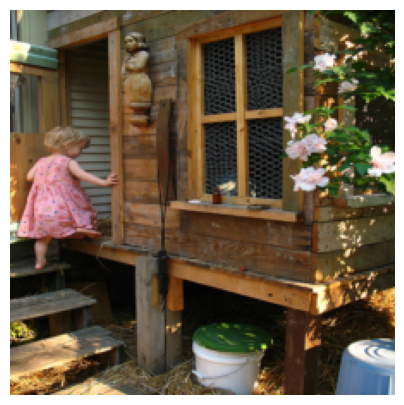

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .


In [7]:
def plot_img(image, caption):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    plt.show()

    print(f"Caption: {' '.join([token for token in caption if token not in [start_token, end_token, pad_token]])}")

# get a picture and caption
full_dataset_iter = iter(Flickr8kDataset(ann))
image, caption, _ = next(full_dataset_iter)
plot_img(image, caption)

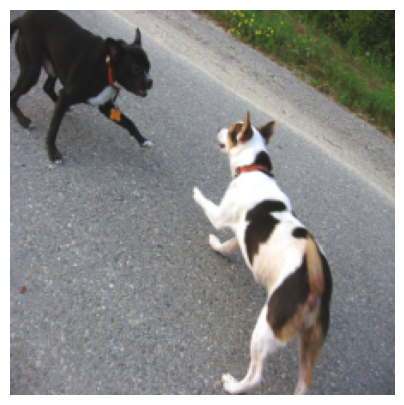

Caption: A black dog and a tri-colored dog playing with each other on the road .


In [8]:
# get another picture an its caption
for i in range(5):
    _, _, _ = next(full_dataset_iter) # Skip 5 captions

image, caption, _ = next(full_dataset_iter)
plot_img(image, caption)

#### Den DataLoader vorbereiten
Hier passiert auch der Train-, Val-, Testsplit.

In [9]:
class Flickr8kDataModule(li.LightningDataModule):
    def __init__(self):
        super().__init__()
        
    def setup(self, stage=None):
        # split by image
        images = ann.image.unique()
        
        # calculate splitsizes
        n_images = len(images)
        n_val_samples = int(n_images * val_ratio)
        n_test_samples = int(n_images * test_ratio)

        # split
        image_split = random_split(
            images,
            [
                n_images - n_val_samples - n_test_samples,
                n_val_samples,
                n_test_samples,
            ],
            generator=seed
        )

        # retrieve image from split
        train_images = images[image_split[0].indices]
        val_images = images[image_split[1].indices]
        test_images = images[image_split[2].indices]
        
        # convert to df for dataset
        train_ann = ann[ann["image"].isin(train_images)]
        val_ann = ann[ann["image"].isin(val_images)]
        test_ann = ann[ann["image"].isin(test_images)]

        # get datasets
        self.train_dataset = Flickr8kDataset(train_ann)
        self.val_dataset = Flickr8kDataset(val_ann)
        self.test_dataset = Flickr8kDataset(test_ann)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=batch_size, num_workers=num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=batch_size, num_workers=num_workers)

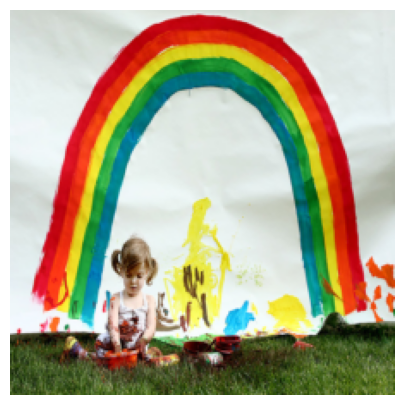

Caption: A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .


In [10]:
flickr8k = Flickr8kDataModule()
flickr8k.setup()

image, caption, caption_tensor = flickr8k.train_dataset[0]
plot_img(image, caption)

Seems to be working :)

### Schritt 2: Aufbau Modellierung 
Überlege Dir, welche Modell-Architektur Sinn machen könnte. Das Paper von Vinyals <br>
(https://arxiv.org/pdf/1411.4555.pdf) war wichtig in diesem Zusammenhang. du kannst <br>
Dich auf Ihre Architektur beziehen oder auch eine eigene, evt. einfachere verwenden.  <br>
Zwei Modell-Varianten sollen aufgebaut werden: 
 
Absprache/Beschluss mit Coach und Beschluss, was evaluiert werden soll. 

#### Den Encoder und Decoder vorbereiten

In [11]:
class ImageEncoder(torch.nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        
        # failed sha256 check workaround: https://github.com/pytorch/vision/issues/7744
        def get_state_dict(self, *args, **kwargs):
            kwargs.pop("check_hash")
            return torch.hub.load_state_dict_from_url(self.url, *args, **kwargs)
        torchvision.models._api.WeightsEnum.get_state_dict = get_state_dict

        # load the model
        self.model = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)

        # freeze all the layers
        for param in self.model.parameters():
            param.requires_grad = False

        # unfreeze the last layer
        for param in self.model.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        # forward pass through the model
        x = self.model(x)
        return x
    
class CaptionEncoder(torch.nn.Embedding):
    def __init__(self, vocab_size, embed_size):
        super(CaptionEncoder, self).__init__(vocab_size, embed_size)

class CaptioningDecoder(torch.nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CaptioningDecoder, self).__init__()
        
        # define the LSTM layer
        self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        # define the output layer
        self.linear = torch.nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input):
        # forward pass through the LSTM layer
        output, _ = self.lstm(input)
        
        # forward pass through the output layer
        output = self.linear(output)

        # forward pass through the softmax layer
        return torch.nn.functional.log_softmax(output, dim=-1)

#### Den Encoder und Decoder testen

In [12]:
img_encoder = ImageEncoder()
img_encoder_out = img_encoder(image.unsqueeze(0))
assert img_encoder(image.unsqueeze(0)).shape[1] == img_embed_size
print("Image Encoder: OK")
print(f"Image Encoder Output Shape: {img_encoder_out.shape}\n")

cap_encoder = CaptionEncoder(vocab_size, embed_size)
cap_encoder_out = cap_encoder(caption_tensor.unsqueeze(0))
assert cap_encoder_out.shape[2] == embed_size
print("Caption Encoder: OK")
print(f"Caption Encoder Output Shape: {cap_encoder_out.shape}\n")

encoded_input = torch.cat((img_encoder_out.unsqueeze(1), cap_encoder_out), 1)
print(f"Encoded Input Shape: {encoded_input.shape}\n")

cap_decoder = CaptioningDecoder(embed_size, hidden_size_lstm, vocab_size, num_layers_lstm)
cap_decoder_out = cap_decoder(encoded_input)
assert cap_decoder_out.shape[2] == vocab_size
print("Caption Decoder: OK")
print(f"Caption Decoder Output Shape: {cap_decoder_out.shape}")

Image Encoder: OK
Image Encoder Output Shape: torch.Size([1, 1000])

Caption Encoder: OK
Caption Encoder Output Shape: torch.Size([1, 40, 1000])

Encoded Input Shape: torch.Size([1, 41, 1000])

Caption Decoder: OK
Caption Decoder Output Shape: torch.Size([1, 41, 9634])


#### Creating Model

In [46]:
class NIC(li.LightningModule):
    def __init__(self, lr=0.001, weight_decay=0.0, max_caption_length=20):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_caption_length = max_caption_length
        
        # image embedding
        self.img_encoder = ImageEncoder()
        
        # word embedding
        self.caption_encoder = CaptionEncoder(vocab_size, embed_size)
        
        # caption decoding
        self.captioning_decoder = CaptioningDecoder(embed_size, hidden_size_lstm, vocab_size, num_layers_lstm)
        
        # loss function 
        self.loss_function = nn.CrossEntropyLoss()
    
    def forward(self, images, captions):
        # encode the images and captions
        embedded_images = self.img_encoder(images).unsqueeze(1)
        embedded_captions = self.caption_encoder(captions)
        
        # concatenate the features and captions
        embedded_captions = torch.cat((embedded_images, embedded_captions), 1)

        # decode the captions
        return self.captioning_decoder(embedded_captions)
    
    def generate_caption(self, image, max_caption_length=None):
        with torch.no_grad():

            # encode the image
            img_features = self.img_encoder(image).unsqueeze(1)
            
            # initialize the caption with the start token
            current_token = torch.tensor(tokens_str_to_int([start_token]), device=img_features.device).unsqueeze(0)

            for i in range(max_caption_length):
                # embed the current token
                embedded_token = self.caption_encoder(current_token)

                # concatenate the image features and caption
                embedded_caption = torch.cat((img_features, embedded_token), 1)

                # decode the caption
                output = self.captioning_decoder(embedded_caption)

                # get the next token
                current_token = torch.cat((current_token, output.argmax(dim=-1)[:,-1].unsqueeze(0)), 1)

                # check if the caption is finished
                if current_token[:,-1].item() == tokens_str_to_int([end_token]):
                    break

                # check if the caption reached the maximum length
                if i == max_caption_length - 1:
                    break

            # convert the caption to a list of tokens
            return current_token
        
    def _step(self, batch, batch_idx):
        images, _, captions = batch
        outputs = self(images, captions)
        outputs = outputs[:, :-1, :].permute(0, 2, 1)

        return self.loss_function(outputs, captions)
    
    def training_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, _):
        loss = self._step(batch, _)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay) 


### Schritt 3: Training und Evaluation 
Trainiere und evaluiere das Modell. Beschreibe genau was Du tust und warum Du es tust. 

In [47]:
model = NIC()
#wandb_logger = li.loggers.WandbLogger(log_model='all')

trainer = li.Trainer(
    max_epochs=1,
#    logger=wandb_logger
)

#wandb_logger.watch(model)

trainer.fit(model, flickr8k.train_dataloader(), flickr8k.val_dataloader())

#wandb.finish()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [48]:
# Print an example prediction
# Put model in evaluation mode
model.eval()

image, caption, _ = flickr8k.train_dataset[10]
output = model.generate_caption(image.unsqueeze(0), 20)
output = tokens_int_to_str(output.tolist()[0])
output

['<start>',
 '<start>',
 '<start>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

### Schritt 4: Präsentation / Bericht 
- Präsentation (~10m): Kurze Präsentation mit Diskussion der wichtigsten Ergebnisse. <br> 
- Q&A (~10min): Klärung von Verständnisfragen zum Paper und der Umsetzung. <br>
- Bericht in Form eines gut dokumentierten, übersichtlichen Jupyter Notebooks. 

Dieses soll schliesslich auch abgegeben werden und dem Fachexperten erlauben, die <br>
Schritte nachzuvollziehen (allenfalls auch das Training erneut laufen zu lassen). <br>

## Beurteilung 
Beurteilt wird auf Basis des abgegebenen Notebooks:  
- Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung. 
- Klare, gut-strukturierte Umsetzung.  
- Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut <br> kommentierten Plots und Tabellen. 
- Vernünftiger Umgang mit (Computing-)Ressourcen. 
- Verständliche Präsentation der Ergebnisse.

## Referenzen, Key Words 
- Word Embedding (z.B. word2vec, glove), um Wörter in numerische Vektoren in einem <br> geeignet dimensionierten Raum zu mappen. Siehe z.B. Andrew Ng, Coursera: <br>https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s  
- Bild Embedding mittels vortrainierten (evt. retrained) Netzwerken wie beispielsweise <br>ResNet, GoogLeNet, EfficientNet oder ähnlich. Transfer-Learning. 
- Seq2Seq Models bekannt für Sprach-Übersetzung.  